
In this third lab of the lab, you'll be using again the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over FNIST.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
from google.colab import drive

drive.mount('/content/gdrive')
Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

  0%|          | 16384/26421880 [00:00<02:49, 155686.68it/s]

26427392it [00:00, 79011382.89it/s]                            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


32768it [00:00, 469336.02it/s]
  2%|▏         | 98304/4422102 [00:00<00:04, 935173.05it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 21634566.69it/s]                         
8192it [00:00, 155435.25it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


> **Exercise:** Create a validation set using the 20% of train images

In [ ]:
# YOUR CODE HERE

import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

frac_train = 0.8

size_train_data=trainloader.dataset.train_data.shape[0]

data_valid = int(size_train_data*frac_train)


trainloader.dataset.data = trainloader.dataset.data[:data_valid,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:data_valid]
#We take the 20% images for validation
validloader.dataset.data = validloader.dataset.data[data_valid:,:,:]
validloader.dataset.targets = validloader.dataset.targets[data_valid:]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [ ]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that FMNIST images are $28\times28$ (instead of $32\times32$), so some of the spatial dimensions in the image above are different.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [ ]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        #stride=1 porque nos movemos por los pixeles de las imagenes de 1 en 1
      
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
        # Linear layers
        self.linear1 = nn.Linear(16 * self.final_dim**2,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,10)
      
        # Non-linear activation functions
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
      
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        # Convolutional layers
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x) 
        x = self.pool(x)
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        # Dense layers
        x=self.linear1(x)
        x = self.relu(x) 
        x=self.linear2(x)
        x = self.relu(x) 
        x=self.linear3(x)
        x=self.logsoftmax(x)
        
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [ ]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
    
        super().__init__(dimx,nlabels)  
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()               
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
         # A list to store the loss evolution along validation
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.
            valid_loss = 0.

            # Training
            for images, labels in trainloader:              
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                # watch out! no tenemos que pasarle la imagen flattened sino la imagen completa
                #before:images.view(images.shape[0], -1)
                #after: images
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            # Validation
            with torch.no_grad():   
              for images, labels in validloader:
                  out_val = self.forward(images)
                  loss_val = self.criterion(out_val,labels)
                  valid_loss += loss_val.item()
        
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(valid_loss/len(validloader))
                
            if(e % 10 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def eval_performance(self,dataloader):
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1)) 
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            return accuracy/len(dataloader)

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

Epoch 0. Training loss: 0.969582, Validation loss: 0.591619, Time per epoch: 11.998113 seconds
Train Accuracy 0.862803
Test Accuracy 0.850000
Validation Accuracy 0.855421


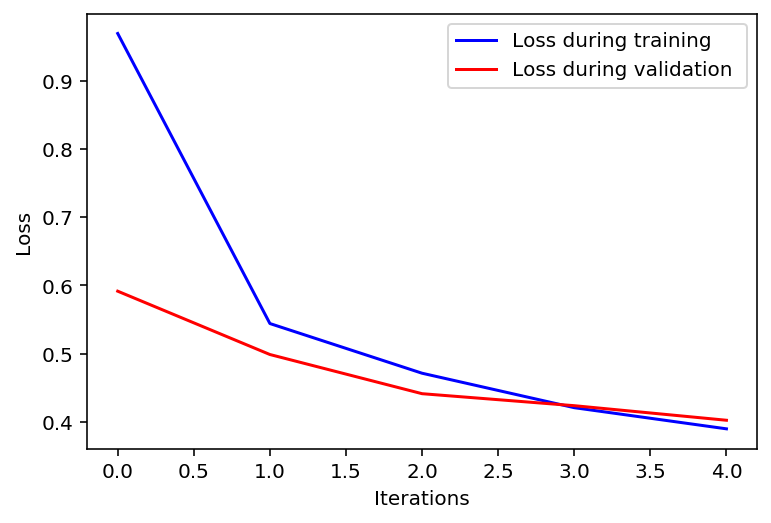

In [ ]:
# Train and validation
my_CNN = Lenet5_extended(dimx=28,nlabels=10,epochs=5,lr=1e-3)
my_CNN.trainloop(trainloader,validloader)

# Train / validation loss
plt.plot(my_CNN.loss_during_training,'-b',label='Loss during training')
plt.plot(my_CNN.valid_loss_during_training,'-r',label='Loss during validation ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
#Performance evaluation
train_performance = my_CNN.eval_performance(trainloader)
test_performance = my_CNN.eval_performance(testloader)
valid_performance = my_CNN.eval_performance(validloader)
print("Train Accuracy %f" %(train_performance))
print("Test Accuracy %f" %(test_performance))
print("Validation Accuracy %f" %(valid_performance))


## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**

In [ ]:
class Lenet5_extended_GPU(Lenet5):
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        super().__init__(dimx,nlabels)  
        # Uses a GPU if possible, otherwise CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)    
        self.lr = lr 
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()              
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        # A list to store the loss evolution along validation
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):    
        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            # YOUR CODE HERE
            running_loss = 0.
            valid_loss = 0.
            for images, labels in trainloader: 
                images, labels = images.to(self.device), labels.to(self.device) 
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            with torch.no_grad():   
              for images, labels in validloader:
                  images, labels = images.to(self.device), labels.to(self.device)  
                  out_val = self.forward(images)
                  loss_val = self.criterion(out_val,labels)
                  valid_loss += loss_val.item()

            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(valid_loss/len(validloader))
    
            if(e % 10 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                # Your code here
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1)) 
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)
    

> **Exercise:** By using Google Colab or a computer with a GPU, train the model for 5 epochs and check how long does it take now to train one epoch.

Epoch 0. Training loss: 0.939523, Validation loss: 0.645160, Time per epoch: 6.553697 seconds


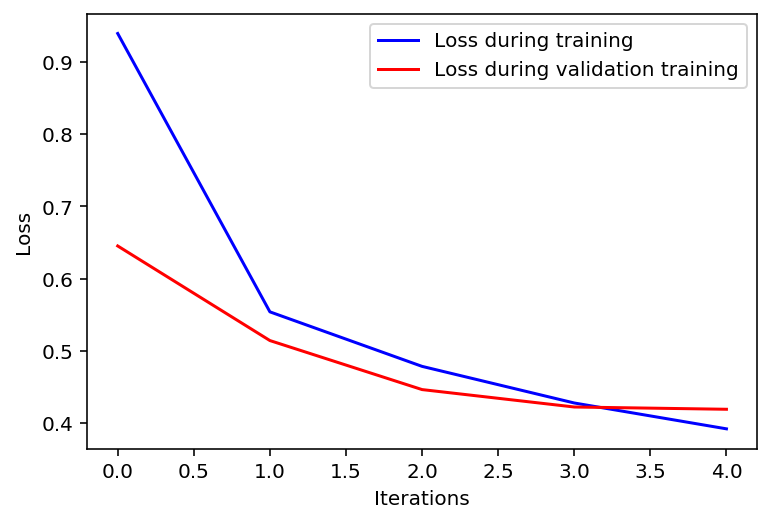

In [ ]:
# YOUR CODE HERE
my_CNN_GPU = Lenet5_extended_GPU(dimx=28,nlabels=10,epochs=5,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)
plt.plot(my_CNN_GPU.loss_during_training,'-b',label='Loss during training')
plt.plot(my_CNN_GPU.valid_loss_during_training,'-r',label='Loss during validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()


Time per epoch using **CPU**: 13.247389 seconds 

Time per epoch using **GPU**: 7.084331 seconds

With a GPU, you will see that the time per epoch roughly decreases to the half. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. You can use a dropout layer after every layer of the network or only in one or two layers. **Validate this effect by comparing two different designs.** Note that once you include dropout, it wil take more epochs to get a good solution. The more dropout layers, the more epochs typically you have to run at least 50 epochs.
> - Compare the test performance achieved w.r.t. the MLP that was used in Lab 2

Epoch 0. Training loss: 0.910394, Validation loss: 0.618941, Time per epoch: 6.462943 seconds


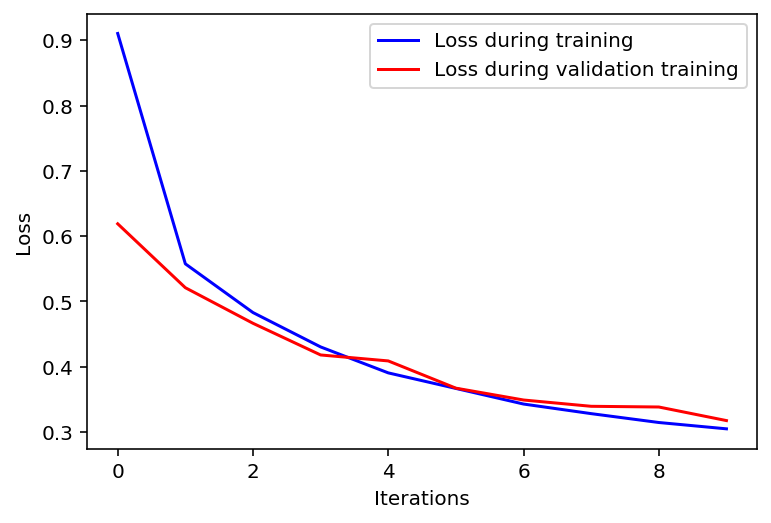

In [ ]:
# YOUR CODE HERE

# We try with 10 epochs to see overfitting
my_CNN_GPU_valid = Lenet5_extended_GPU(dimx=28,nlabels=10,epochs=10,lr=1e-3)
my_CNN_GPU_valid.trainloop(trainloader,validloader)

plt.plot(my_CNN_GPU_valid.loss_during_training,'-b',label='Loss during training')
plt.plot(my_CNN_GPU_valid.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()


Then, we reduce the number of epochs to 3 to not see overfitting (**early stopping**)

Epoch 0. Training loss: 0.911246, Validation loss: 0.578709, Time per epoch: 6.470942 seconds


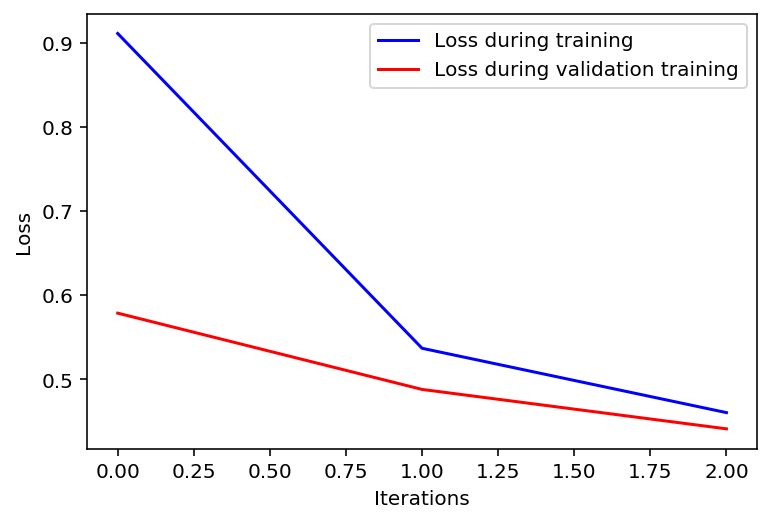

In [ ]:
# We try with 3 epochs to not see overfitting
my_CNN_GPU_valid = Lenet5_extended_GPU(dimx=28,nlabels=10,epochs=3,lr=1e-3)
my_CNN_GPU_valid.trainloop(trainloader,validloader)

plt.plot(my_CNN_GPU_valid.loss_during_training,'-b',label='Loss during training')
plt.plot(my_CNN_GPU_valid.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

**DROPOUT**

In [ ]:
# YOUR CODE HERE
class Lenet5_dropout(nn.Module):
    def __init__(self,dimx,nlabels): 
        super().__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        # Linear layers
        # YOUR CODE HERE
        self.linear1 = torch.nn.Linear(16*self.final_dim**2, 120)   
        self.linear2 = torch.nn.Linear(120, 84)       
        self.linear3 = torch.nn.Linear(84, 10)        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        # Dropout with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)    
        x = self.conv2(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        # YOUR CODE HERE
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
  
        x = self.linear3(x)
        x = self.logsoftmax(x)
        
        return x

    def forward_full(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.conv2(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.dropout(x)
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        # YOUR CODE HERE
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.logsoftmax(x)
        
        return x

    def forward_partial(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        # YOUR CODE HERE
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        

        x = self.linear3(x)
        x = self.logsoftmax(x)
        
        return x


In [ ]:
class Lenet5_extended_GPU_dropout(Lenet5_dropout):
    
    def __init__(self,dimx,nlabels,dropout_mood,epochs=100,lr=0.001):    
        super().__init__(dimx,nlabels)  
        self.dropout_mood = dropout_mood
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()               
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        # Optimization Loop
        for e in range(int(self.epochs)):  
            start_time = time.time()
            running_loss = 0.
            valid_loss = 0.
            for images, labels in trainloader: 
                images, labels = images.to(self.device), labels.to(self.device) 
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                if (self.dropout_mood=='partial'):            
                  out = self.forward_partial(images)
                else:       
                  out = self.forward_full(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                #Your code here
                loss.backward()
                self.optim.step()

            with torch.no_grad():   
              self.eval()
              for images, labels in validloader:
                  images, labels = images.to(self.device), labels.to(self.device)  
                  if (self.dropout_mood=='partial'):            
                    out_val = self.forward_partial(images)
                  else:       
                    out_val = self.forward_full(images)
                  loss_val = self.criterion(out_val,labels)
                  valid_loss += loss_val.item()

            self.train()
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(valid_loss/len(validloader))
        
            if(e % 10 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
      
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 

                # Your code here
                probs = my_CNN.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1)) 
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)
    

Epoch 0. Training loss: 0.984462, Validation loss: 0.604766, Time per epoch: 6.565831 seconds
Epoch 10. Training loss: 0.346934, Validation loss: 0.324779, Time per epoch: 6.478969 seconds
Epoch 20. Training loss: 0.291083, Validation loss: 0.280853, Time per epoch: 6.357750 seconds
Epoch 30. Training loss: 0.261770, Validation loss: 0.274666, Time per epoch: 6.466438 seconds
Epoch 40. Training loss: 0.246049, Validation loss: 0.270400, Time per epoch: 6.474092 seconds
Epoch 50. Training loss: 0.227457, Validation loss: 0.261751, Time per epoch: 6.445896 seconds
Epoch 60. Training loss: 0.219047, Validation loss: 0.267086, Time per epoch: 6.357003 seconds
Epoch 0. Training loss: 1.071963, Validation loss: 0.617318, Time per epoch: 6.378427 seconds
Epoch 10. Training loss: 0.398717, Validation loss: 0.338266, Time per epoch: 6.560300 seconds
Epoch 20. Training loss: 0.343440, Validation loss: 0.304474, Time per epoch: 6.431102 seconds
Epoch 30. Training loss: 0.313597, Validation loss: 

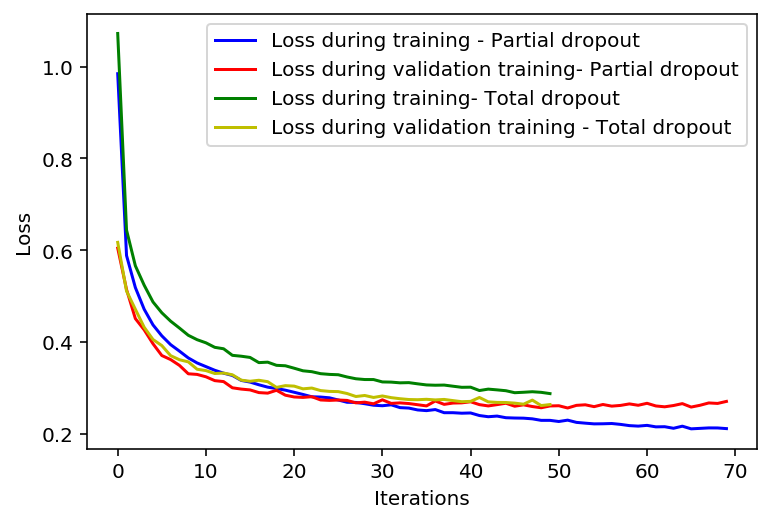

In [ ]:

# Dropout en algunas capas
my_CNN_GPU_dropout_partial = Lenet5_extended_GPU_dropout(dimx=28,nlabels=10,dropout_mood='partial',epochs=70,lr=1e-3)
my_CNN_GPU_dropout_partial.trainloop(trainloader,validloader)
plt.plot(my_CNN_GPU_dropout_partial.loss_during_training,'-b',label='Loss during training - Partial dropout')
plt.plot(my_CNN_GPU_dropout_partial.valid_loss_during_training,'-r',label='Loss during validation training- Partial dropout')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
# Dropout en todas las capas

my_CNN_GPU_dropout_full = Lenet5_extended_GPU_dropout(dimx=28,nlabels=10,dropout_mood='full',epochs=50,lr=1e-3)
my_CNN_GPU_dropout_full.trainloop(trainloader,validloader)
plt.plot(my_CNN_GPU_dropout_full.loss_during_training,'-g',label='Loss during training- Total dropout')
plt.plot(my_CNN_GPU_dropout_full.valid_loss_during_training,'-y',label='Loss during validation training - Total dropout')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()